In [ ]:
!odsc conda install -s fspyspark32_p38_cpu_v2

In [ ]:
!pip install transformers datasets evaluate

Oracle Data Science service sample notebook.

Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">Synthetic data generation in feature store using OpenAI and FewShotPromptTemplate</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

---
# Overview:
---
Synthetic data is artificially generated data, rather than data collected from real-world events. It's used to simulate real data without compromising privacy or encountering real-world limitations. 

Benefits of Synthetic Data:

1. **Privacy and Security**: No real personal data at risk of breaches.
2. **Data Augmentation**: Expands datasets for machine learning.
3. **Flexibility**: Create specific or rare scenarios.
4. **Cost-effective**: Often cheaper than real-world data collection.
5. **Regulatory Compliance**: Helps navigate strict data protection laws.
6. **Model Robustness**: Can lead to better generalizing AI models.
7. **Rapid Prototyping**: Enables quick testing without real data.
8. **Controlled Experimentation**: Simulate specific conditions.
9. **Access to Data**: Alternative when real data isn't available.

Note: Despite the benefits, synthetic data should be used carefully, as it may not always capture real-world complexities.


Compatible conda pack: [PySpark 3.2 and Feature store](https://docs.oracle.com/iaas/data-science/using/conda-pyspark-fam.htm) for CPU on Python 3.8

## Contents:

- <a href="#concepts">1. Introduction</a>
- <a href='#pre-requisites'>1. Pre-requisites</a>
    - <a href='#policies'>2.1 Policies</a>
    - <a href='#prerequisites_authentication'>2.2 Authentication</a>
    - <a href='#prerequisites_variables'>2.3 Variables</a>
- <a href='#featurestore_querying'>3. Feature store querying</a>
    - <a href='#data_exploration'>3.1. Exploration of data in feature store</a>
    - <a href='#load_featuregroup'>3.2. Load feature groups</a>
    - <a href='#explore_featuregroup'>3.3. Explore feature groups</a>
    - <a href='#select_subset_featuregroup'>3.4. Select subset of features</a>
    - <a href='#filter_featuregroup'>3.5. Filter feature groups</a>
    - <a href='#join_featuregroup'>3.6. Apply joins on feature group</a>
    - <a href='#create_dataset'>3.7. Create dataset from multiple or one feature group</a>
    - <a href='#sql_query'>3.8 Free form sql query</a>
- <a href='#ref'>4. References</a>

---

**Important:**

Placeholder text for required values are surrounded by angle brackets that must be removed when adding the indicated content. For example, when adding a database name to `database_name = "<database_name>"` would become `database_name = "production"`.

---

<a id="concepts"></a>
# 1. Introduction

Oracle feature store is a stack based solution that is deployed in the customer enclave using OCI resource manager. Customer can stand up the service with infrastructure in their own tenancy. The service consists of API which are deployed in customer tenancy using resource manager.

The following are some key terms that will help you understand OCI Data Science Feature Store:


* **Feature Vector**: Set of feature values for any one primary/identifier key. Eg. All/subset of features of customer id ‘2536’ can be called as one feature vector.

* **Feature**: A feature is an individual measurable property or characteristic of a phenomenon being observed.

* **Entity**: An entity is a group of semantically related features. The first step a consumer of features would typically do when accessing the feature store service is to list the entities and the entities associated features. Another way to look at it is that an entity is an object or concept that is described by its features. Examples of entities could be customer, product, transaction, review, image, document, etc.

* **Feature Group**: A feature group in a feature store is a collection of related features that are often used together in ml models. It serves as an organizational unit within the feature store for users to manage, version and share features across different ml projects. By organizing features into groups, data scientists and ml engineers can efficiently discover, reuse and collaborate on features reducing the redundant work and ensuring consistency in feature engineering.

* **Feature Group Job**: Feature group job is the execution instance of a feature group. Each feature group job will include validation results and statistics results.

* **Dataset**: A dataset is a collection of feature that are used together to either train a model or perform model inference.

* **Dataset Job**: Dataset job is the execution instance of a dataset. Each dataset job will include validation results and statistics results.

<a id='pre-requisites'></a>
# 2. Pre-requisites

Data Flow Sessions are accessible through the following conda environment:

* **PySpark 3.2, Feature store 1.0 and Data Flow 1.0 (fs_pyspark32_p38_cpu_v1)**

The [Data Catalog Hive Metastore](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm) provides schema definitions for objects in structured and unstructured data assets. The Metastore is the central metadata repository to understand tables backed by files on object storage. You can customize `fs_pyspark32_p38_cpu_v1`, publish it, and use it as a runtime environment for a Data Flow session cluster. The metastore id of hive metastore is tied to feature store construct of feature store service.


<a id='setup_spark-defaults'></a>
### `spark-defaults.conf`

The `spark-defaults.conf` file is used to define the properties that are used by Spark. A templated version is installed when you install a Data Science conda environment that supports PySpark. However, you must update the template so that the Data Catalog metastore can be accessed. You can do this manually. However, the `odsc data-catalog config` commandline tool is ideal for setting up the file because it gathers information about your environment, and uses that to build the file.

The `odsc data-catalog config` command line tool needs the `--metastore` option to define the Data Catalog metastore OCID. No other command line option is needed because settings have default values, or they take values from your notebook session environment. Following are common parameters that you may need to override.

The `--authentication` option sets the authentication mode. It supports resource principal and API keys. The preferred method for authentication is resource principal, which is sent with `--authentication resource_principal`. If you want to use API keys, then use the `--authentication api_key` option. If the `--authentication` isn't specified, API keys are used. When API keys are used, information from the OCI configuration file is used to create the `spark-defaults.conf` file.

Object Storage and Data Catalog are regional services. By default, the region is set to the region your notebook session is running in. This information is taken from the environment variable, `NB_REGION`. Use the `--region` option to override this behavior.

The default location of the `spark-defaults.conf` file is `/home/datascience/spark_conf_dir` as defined in the `SPARK_CONF_DIR` environment variable. Use the `--output` option to define the directory where to write the file.

You need to determine what settings are appropriate for your configuration. However, the following works for most configurations and is run in a terminal window.

```bash
odsc data-catalog config --authentication resource_principal --metastore <metastore_id>
```
For more assistance, use the following command in a terminal window:

```bash
odsc data-catalog config --help
```

<a id='setup_session'></a>
### Session Setup

The notebook makes connections to the Data Catalog metastore and Object Storage. In the next cell, specify the bucket URI to act as the data warehouse. Use the `warehouse_uri` variable with the `oci://<bucket_name>@<namespace_name>/<key>` format. Update the variable `metastore_id` with the OCID of the Data Catalog metastore.

python -m pip install --pre oracle-ads==2.9.0rc0<a id='policies'></a>
### 2.1. Policies
This section covers the creation of dynamic groups and policies needed to use the service.

* [Data Flow Policies](https://docs.oracle.com/iaas/data-flow/using/policies.htm/)
* [Data Catalog Metastore Required Policies](https://docs.oracle.com/en-us/iaas/data-catalog/using/metastore.htm)
* [Getting Started with Data Flow](https://docs.oracle.com/iaas/data-flow/using/dfs_getting_started.htm)
* [About Data Science Policies](https://docs.oracle.com/iaas/data-science/using/policies.htm)

In [1]:
!pip install --pre --no-deps oracle-ads==2.9.0rc0 

  Obtaining dependency information for oracle-ads==2.9.0rc0 from https://files.pythonhosted.org/packages/da/5a/155af49717f08104e7eabf682ffcd1344a3d78d63ff8aedb8ef392bebc6c/oracle_ads-2.9.0rc0-py3-none-any.whl.metadata
  Using cached oracle_ads-2.9.0rc0-py3-none-any.whl.metadata (11 kB)
Using cached oracle_ads-2.9.0rc0-py3-none-any.whl (4.3 MB)
  Attempting uninstall: oracle-ads
    Found existing installation: oracle-ads 2.8.8
    Uninstalling oracle-ads-2.8.8:
      Successfully uninstalled oracle-ads-2.8.8


<a id="prerequisites_authentication"></a>
### 2.2. Authentication
The [Oracle Accelerated Data Science SDK (ADS)](https://docs.oracle.com/iaas/tools/ads-sdk/latest/index.html) controls the authentication mechanism with the notebook cluster.<br>
To setup authentication use the ```ads.set_auth("resource_principal")``` or ```ads.set_auth("api_key")```.

In [1]:
import ads
ads.set_auth(auth="resource_principal", client_kwargs={"service_endpoint": "<endpoint>"})

<a id="prerequisites_variables"></a>
### 2.3. Variables
To run this notebook, you must provide some information about your tenancy configuration. To create and run a feature store, you must specify a `<compartment_id>` and bucket `<metastore_id>` for offline feature store.

In [2]:
import os

compartment_id = "<compartment_id>"
metastore_id = "<metastore_id>"

<a id="featurestore_querying"></a>
# 3. Feature group use cases
By default the **PySpark 3.2, Feature store and Data Flow** conda environment includes pre-installed [great-expectations](https://legacy.docs.greatexpectations.io/en/latest/reference/core_concepts/validation.html) and [deeque](https://github.com/awslabs/deequ) libraries. The joining functionality is heavily inspired by the APIs used by Pandas to merge, join or filter DataFrames. The APIs allow you to specify which features to select from which feature group, how to join them and which features to use in join conditions.

In [3]:
import warnings
warnings.filterwarnings("ignore", message="iteritems is deprecated")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
import pandas as pd
from ads.feature_store.feature_store import FeatureStore
from ads.feature_store.feature_group import FeatureGroup
from ads.feature_store.model_details import ModelDetails
from ads.feature_store.dataset import Dataset
from ads.feature_store.common.enums import DatasetIngestionMode


from ads.feature_store.feature_group_expectation import ExpectationType
from great_expectations.core import ExpectationSuite, ExpectationConfiguration
from ads.feature_store.feature_store_registrar import FeatureStoreRegistrar

  from .model_deployment_properties import ModelDeploymentProperties

  from .model_deployer import ModelDeployer

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):

  LooseVersion(pyarrow.__version__) >= LooseVersion("2.0.0")

  if LooseVersion(pd.__version__) >= LooseVersion("0.24"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) < LooseVersion("1.0"):

  if LooseVersion(pd.__version__) >= LooseVersion("1.3.0"):

Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore

Implementing implicit na

<a id="data_exploration"></a>
### 3.1. Exploration of data in feature store

#### 3.1.1 Load Synthetic dataset

The `FewShotPromptTemplate` includes:

- `prefix` and `suffix`: These likely contain guiding context or instructions.
- `examples`: The sample data we defined earlier.
- `input_variables`: These variables ("subject", "extra") are placeholders you can dynamically fill later. For instance, "subject" might be filled with "medical_billing" to guide the model further.
- `example_prompt`: This prompt template is the format we want each example row to take in our prompt.

<a id="load_featuregroup"></a>
### 3.2. Create feature store logical entities

#### 3.2.1 Feature Store
Feature store is the top level entity for feature store service

In [5]:
feature_store_resource = (
    FeatureStore().
    with_description("Medical Synthetic Data Feature Store").
    with_compartment_id(compartment_id).
    with_display_name("Synthetic data details").
    with_offline_config(metastore_id=metastore_id)
)

<a id="create_feature_store"></a>
##### Create Feature Store

Call the ```.create()``` method of the Feature store instance to create a feature store.

In [6]:
feature_store = feature_store_resource.create()
feature_store


kind: featurestore
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: Medical Synthetic Data Feature Store
  displayName: Synthetic data details
  id: 22F0AE1826B035E226A1C6A41C07C299
  offlineConfig:
    metastoreId: ocid1.datacatalogmetastore.oc1.iad.amaaaaaabiudgxyap7tizm4gscwz7amu7dixz7ml3mtesqzzwwg3urvvdgua
type: featureStore

#### 3.2.2 Entity
An entity is a logical segregation of feature store entities

In [7]:
entity = feature_store.create_entity(
    display_name="Synthetic Medical Entity",
    description="description for medical entity details"
)
entity


kind: entity
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  description: description for medical entity details
  featureStoreId: 22F0AE1826B035E226A1C6A41C07C299
  id: 8B1A0CCD3AEA4A63A52907E90A4D0F3F
  name: Synthetic Medical Entity
type: entity

#### 3.2.3 Transformation

In [8]:
!pip install -U langchain langchain_experimental openai

In [9]:
!pip install python-dotenv

In [10]:
def generate_synthetic_data(dataframe):
    import pandas as pd
    import dotenv
    from langchain.prompts import FewShotPromptTemplate, PromptTemplate
    from langchain.chat_models import ChatOpenAI
    from langchain.pydantic_v1 import BaseModel
    from langchain_experimental.tabular_synthetic_data.base import SyntheticDataGenerator
    from langchain_experimental.tabular_synthetic_data.openai import create_openai_data_generator
    from langchain_experimental.tabular_synthetic_data.prompts import SYNTHETIC_FEW_SHOT_SUFFIX, SYNTHETIC_FEW_SHOT_PREFIX

    # Set env var OPENAI_API_KEY or load from a .env file:
    dotenv.load_dotenv()

    class MedicalBilling(BaseModel):
        patient_id: int
        patient_name: str
        diagnosis_code: str
        procedure_code: str
        total_charge: float
        insurance_claim_amount: float

    examples = [
        {
            "example": """Patient ID: 123456, Patient Name: John Doe, Diagnosis Code: 
            J20.9, Procedure Code: 99203, Total Charge: $500, Insurance Claim Amount: $350"""
        },
        {
            "example": """Patient ID: 789012, Patient Name: Johnson Smith, Diagnosis 
            Code: M54.5, Procedure Code: 99213, Total Charge: $150, Insurance Claim Amount: $120"""
        },
        {
            "example": """Patient ID: 345678, Patient Name: Emily Stone, Diagnosis Code: 
            E11.9, Procedure Code: 99214, Total Charge: $300, Insurance Claim Amount: $250"""
        },
    ]

    OPENAI_TEMPLATE = PromptTemplate(input_variables=["example"], template="{example}")

    prompt_template = FewShotPromptTemplate(
        prefix=SYNTHETIC_FEW_SHOT_PREFIX,
        examples=examples,
        suffix=SYNTHETIC_FEW_SHOT_SUFFIX,
        input_variables=["subject", "extra"],
        example_prompt=OPENAI_TEMPLATE,
    )

    synthetic_data_generator = create_openai_data_generator(
        output_schema=MedicalBilling,
        llm=ChatOpenAI(
            temperature=1
        ),  # You'll need to replace with your actual Language Model instance
        prompt=prompt_template,
    )

    synthetic_results = synthetic_data_generator.generate(
        subject="medical_billing",
        extra="the name must be chosen at random. Make it something you wouldn't normally choose.",
        runs=1,
    )

    # Convert to DataFrame
    df = pd.DataFrame([result.dict() for result in synthetic_results])
    return df

In [11]:
from ads.feature_store.transformation import TransformationMode

synthetic_transformation = feature_store.create_transformation(
    transformation_mode=TransformationMode.PANDAS,
    source_code_func=generate_synthetic_data,
    display_name="generate_synthetic_data",
)

synthetic_transformation


kind: transformation
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  displayName: generate_synthetic_data
  featureStoreId: 22F0AE1826B035E226A1C6A41C07C299
  id: D3666026ED85F082B62B1142AA6B77DD
  sourceCode: ZGVmIGdlbmVyYXRlX3N5bnRoZXRpY19kYXRhKGRhdGFmcmFtZSk6CiAgICBpbXBvcnQgcGFuZGFzIGFzIHBkCiAgICBpbXBvcnQgZG90ZW52CiAgICBmcm9tIGxhbmdjaGFpbi5wcm9tcHRzIGltcG9ydCBGZXdTaG90UHJvbXB0VGVtcGxhdGUsIFByb21wdFRlbXBsYXRlCiAgICBmcm9tIGxhbmdjaGFpbi5jaGF0X21vZGVscyBpbXBvcnQgQ2hhdE9wZW5BSQogICAgZnJvbSBsYW5nY2hhaW4ucHlkYW50aWNfdjEgaW1wb3J0IEJhc2VNb2RlbAogICAgZnJvbSBsYW5nY2hhaW5fZXhwZXJpbWVudGFsLnRhYnVsYXJfc3ludGhldGljX2RhdGEuYmFzZSBpbXBvcnQgU3ludGhldGljRGF0YUdlbmVyYXRvcgogICAgZnJvbSBsYW5nY2hhaW5fZXhwZXJpbWVudGFsLnRhYnVsYXJfc3ludGhldGljX2RhdGEub3BlbmFpIGltcG9ydCBjcmVhdGVfb3BlbmFpX2RhdGFfZ2VuZXJhdG9yCiAgICBmcm9tIGxhbmdjaGFpbl9leHBlcmltZW50YWwudGFidWxhcl9zeW50aGV0aWNfZGF0YS5wcm9tcHRzIGltcG9ydCBTWU5USEVUSUNfRkVXX1NIT1RfU1VGRklYLCBTWU5USEVUSUNfRkVX

#### 3.2.3 Feature group
A feature group is an object that represents a logical group of time-series feature data as it is found in a datasource.

<a id="create_feature_group_flights"></a>
##### Synthetic medical feature Group

Create feature group for Synthetic Dataset Feature Group

<div>
    <img src="https://objectstorage.us-ashburn-1.oraclecloud.com/p/hh2NOgFJbVSg4amcLM3G3hkTuHyBD-8aE_iCsuZKEvIav1Wlld-3zfCawG4ycQGN/n/ociodscdev/b/oci-feature-store/o/beta/_images/feature_group_flights.gif" width="700" height="350" />
</div>

In [12]:
empty_df = pd.DataFrame([{
    "patient_id": 123456,
    "patient_name": "John Doe",
    "diagnosis_code": "J20.9",
    "procedure_code": "99203",
    "total_charge": 500.0,
    "insurance_claim_amount": 350.0,
}])
empty_df

,patient_id,patient_name,diagnosis_code,procedure_code,total_charge,insurance_claim_amount
0,123456,John Doe,J20.9,99203,500.0,350.0


In [13]:
expectation_suite = ExpectationSuite(
    expectation_suite_name="test_synthetic data"
)
expectation_suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "patient_id"},
    )
)
expectation_suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "patient_name"},
    )
)

expectation_suite.add_expectation(
    ExpectationConfiguration(
        expectation_type="expect_column_values_to_not_be_null",
        kwargs={"column": "diagnosis_code"},
    )
)

{"expectation_type": "expect_column_values_to_not_be_null", "kwargs": {"column": "diagnosis_code"}, "meta": {}}

In [14]:
synthetic_data_embedding_feature_group = (
    FeatureGroup()
    .with_feature_store_id(feature_store.id)
    .with_primary_keys([])
    .with_name("synthetic_data_feature_group")
    .with_entity_id(entity.id)
    .with_compartment_id(compartment_id)
    .with_schema_details_from_dataframe(empty_df)
    .with_transformation_id(synthetic_transformation.id)
    .with_expectation_suite(
        expectation_suite=expectation_suite,
        expectation_type=ExpectationType.STRICT,
     )
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023/11/11 06:13:09 NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



In [15]:
synthetic_data_embedding_feature_group.create()


kind: FeatureGroup
spec:
  compartmentId: ocid1.tenancy.oc1..aaaaaaaa462hfhplpx652b32ix62xrdijppq2c7okwcqjlgrbknhgtj2kofa
  entityId: 8B1A0CCD3AEA4A63A52907E90A4D0F3F
  expectationDetails:
    createRuleDetails:
    - arguments:
        column: patient_id
      levelType: ERROR
      name: Rule-0
      ruleType: expect_column_values_to_not_be_null
    - arguments:
        column: patient_name
      levelType: ERROR
      name: Rule-1
      ruleType: expect_column_values_to_not_be_null
    - arguments:
        column: diagnosis_code
      levelType: ERROR
      name: Rule-2
      ruleType: expect_column_values_to_not_be_null
    expectationType: STRICT
    name: test_synthetic data
    validationEngineType: GREAT_EXPECTATIONS
  featureStoreId: 22F0AE1826B035E226A1C6A41C07C299
  id: 4DFC763EE0C63298E9BA88C30E9C582C
  inputFeatureDetails:
  - featureType: LONG
    name: patient_id
    orderNumber: 1
  - featureType: STRING
    name: patient_name
    orderNumber: 2
  - featureType: STRING

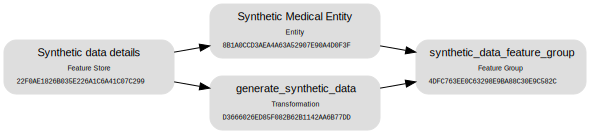

In [16]:
synthetic_data_embedding_feature_group.show()

In [17]:
synthetic_data_embedding_feature_group.materialise(empty_df)

Hive Session ID = 29f04188-c119-4093-b6e1-6f89d2f5be11


INFO:great_expectations.validator.validator:	3 expectation(s) included in expectation_suite.


Calculating Metrics:   0%|          | 0/12 [00:00<?, ?it/s]

INFO:ads.feature_store.common.utils.utility:Validation Summary 
╒════════════════════╤══════════════════════════╤═══════════════════════════╤═════════════════════════════╤═══════════════════╤═══════════════════════╕
│  expectation_type  │  evaluated_expectations  │  successful_expectations  │  unsuccessful_expectations  │  success_percent  │   ingestion_status    │
╞════════════════════╪══════════════════════════╪═══════════════════════════╪═════════════════════════════╪═══════════════════╪═══════════════════════╡
│       STRICT       │            3             │             3             │              0              │        100        │ Ingestion in progress │
╘════════════════════╧══════════════════════════╧═══════════════════════════╧═════════════════════════════╧═══════════════════╧═══════════════════════╛
INFO:ads.feature_store.common.utils.utility:Validations Rules Summary 
╒═════════════════════════════════════╤══════════════════════════════╤══════════╕
│              rule_typ

INFO:mlm_insights.builder:validating required components
INFO:mlm_insights.builder:required components validated
INFO:mlm_insights.builder.usage:Activating Minimal Insights Usage
INFO:mlm_insights.builder:Generating Runner object
INFO:mlm_insights.builder:Generating workflow request
INFO:mlm_insights.workflow:Fetching engine object
INFO:mlm_insights.workflow:Returning native engine object
INFO:mlm_insights.builder:Running Fugue Workflow
INFO:mlm_insights.workflow:Executing Fugue Workflow


INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9c0d320470>), 'c19e3960aa08a392d20aaa5da607d9ea': DescriptiveStatisticsSFC(total_count=1.0, mean=123456.0, minimum=123456.0, maximum=123456.0, central_moments=[1.0, 0.0, 0.0, 0.0, 0.0]), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f9c0c1eba30>), '6e3ac490990d92bca69c828fe3aff8ad': QuantilesSFC(kll_sketch=<_datasketches.kll_doubles_sketch object at 0x7f9c0c1eb970>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_datasketches.frequent_strings_sketch object at 0x7f9c0cefc1b0>), '4cd1d3704778a196571a6c83581854cc': DistinctCountSFC(sketch=<_datasketches.hll_sketch object at 0x7f9c0cefb7f0>)} sfc map
INFO:mlm_insights.core.sfcs:creating sfc from {'c5144335a509689fc50d13d03eebc9b1': FrequentItemsSFC(sketch=<_data

/home/datascience/conda/fspyspark32_p38_cpu_v2/lib/python3.8/site-packages/mlm_insights/core/sfcs/descriptive_statistics_sfc.py:80: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  self.central_moments = [moment(column, moment=i) for i in range(MAXIMUM_MOMENT_ORDER + 1)]
/home/datascience/conda/fspyspark32_p38_cpu_v2/lib/python3.8/site-packages/mlm_insights/core/sfcs/descriptive_statistics_sfc.py:80: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  self.central_moments = [moment(column, moment=i) for i in range(MAXIMUM_MOMENT_ORDER + 1)]
/home/datascience/conda/fspyspark32_p38_cpu_v2/lib/python3.8/site-packages/mlm_insights/core/sfcs/descriptive_statistics_sfc.py:80: RuntimeWarning: Precision loss occurred in moment calculation due to catastr

<a id="explore_featuregroup"></a>
### 3.3. Explore feature groups

In [18]:
# synthetic_data_embedding_feature_group.get_statistics().to_viz()

In [19]:
synthetic_data_embedding_feature_group.history().show()

+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|version|          timestamp|userId|userName|           operation| operationParameters| job|notebook|clusterId|readVersion|isolationLevel|isBlindAppend|    operationMetrics|userMetadata|          engineInfo|
+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+--------------------+------------+--------------------+
|      0|2023-11-11 06:14:11|  null|    null|CREATE OR REPLACE...|{isManaged -> tru...|null|    null|     null|       null|  Serializable|        false|{numFiles -> 1, n...|        null|Apache-Spark/3.2....|
+-------+-------------------+------+--------+--------------------+--------------------+----+--------+---------+-----------+--------------+-------------+----------------

In [20]:
synthetic_data_embedding_feature_group.as_of(version_number=0).show()

+----------+------------+--------------+--------------+------------+----------------------+
|patient_id|patient_name|diagnosis_code|procedure_code|total_charge|insurance_claim_amount|
+----------+------------+--------------+--------------+------------+----------------------+
|    123456|  Jane Smith|         D50.0|         99204|       250.0|                 200.0|
+----------+------------+--------------+--------------+------------+----------------------+



In [21]:
synthetic_data_embedding_feature_group.get_features_df()

,name,type
0,patient_id,LONG
1,patient_name,STRING
2,diagnosis_code,STRING
3,procedure_code,STRING
4,total_charge,DOUBLE
5,insurance_claim_amount,DOUBLE


In [22]:
synthetic_data_embedding_feature_group.get_validation_output().to_pandas()

,0,1,2
success,True,True,True
expectation_config.expectation_type,expect_column_values_to_not_be_null,expect_column_values_to_not_be_null,expect_column_values_to_not_be_null
expectation_config.kwargs.column,patient_id,patient_name,diagnosis_code
expectation_config.kwargs.batch_id,f375a21b5118a85cf380226d22b60f8c,f375a21b5118a85cf380226d22b60f8c,f375a21b5118a85cf380226d22b60f8c
result.element_count,1,1,1
result.unexpected_count,0,0,0
result.unexpected_percent,0.0,0.0,0.0
result.partial_unexpected_list,[],[],[]
exception_info.raised_exception,False,False,False
exception_info.exception_traceback,None,None,None


In [23]:
synthetic_data_embedding_feature_group.select().show()

+----------+------------+--------------+--------------+------------+----------------------+
|patient_id|patient_name|diagnosis_code|procedure_code|total_charge|insurance_claim_amount|
+----------+------------+--------------+--------------+------------+----------------------+
|    123456|  Jane Smith|         D50.0|         99204|       250.0|                 200.0|
+----------+------------+--------------+--------------+------------+----------------------+



<a id="select_subset_featuregroup"></a>
### 3.4. Select subset of features

In [24]:
synthetic_data_embedding_feature_group.select(['patient_id', 'patient_name']).show()

+----------+------------+
|patient_id|patient_name|
+----------+------------+
|    123456|  Jane Smith|
+----------+------------+



<a id="filter_featuregroup"></a>
### 3.5. Filter feature groups

In [25]:
synthetic_data_embedding_feature_group.filter(synthetic_data_embedding_feature_group.patient_id == "123456").show()

+----------+------------+--------------+--------------+------------+----------------------+
|patient_id|patient_name|diagnosis_code|procedure_code|total_charge|insurance_claim_amount|
+----------+------------+--------------+--------------+------------+----------------------+
|    123456|  Jane Smith|         D50.0|         99204|       250.0|                 200.0|
+----------+------------+--------------+--------------+------------+----------------------+



In [26]:
tranining_df = synthetic_data_embedding_feature_group.select().read().toPandas()
tranining_df

  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):

  if LooseVersion(pyarrow.__version__) < LooseVersion(minimum_pyarrow_version):



,patient_id,patient_name,diagnosis_code,procedure_code,total_charge,insurance_claim_amount
0,123456,Jane Smith,D50.0,99204,250.0,200.0


<a id='ref'></a>
# References

- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)